Naiwny klasyfikator bayesowski
---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2), loc=5),
                        np.random.normal(size=(100, 2), loc=7)))
train_labels = np.hstack((np.zeros(100), np.ones(100)))

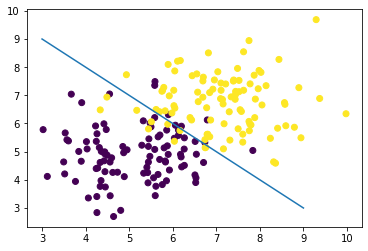

In [3]:
fig, ax = plt.subplots()
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels)
ax.plot(range(3, 10), range(9, 2, -1))
plt.show()

In [4]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [5]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [6]:
clf = GaussianNB()
clf.fit(train_data, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

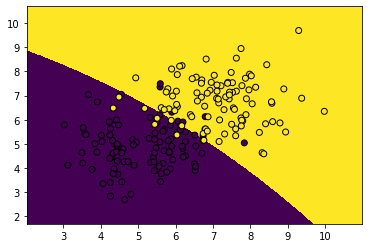

In [7]:
xs, ys = get_grid(train_data)

predicted = clf.predict(
    np.column_stack((xs.flatten(),
                     ys.flatten()))).reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, predicted)
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, edgecolors='k')
plt.show()

In [8]:
clf = MultinomialNB()
clf.fit(train_data, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

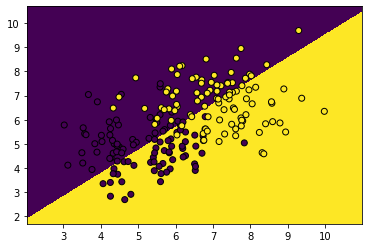

In [9]:
xs, ys = get_grid(train_data)

predicted = clf.predict(
    np.column_stack((xs.flatten(),
                     ys.flatten()))).reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, predicted)
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, edgecolors='k')
plt.show()

Po pierwsze, musimy zaimportować dane. Pobierzmy sobie zatem zbiory z githuba.

In [58]:
!git clone https://github.com/PiotrJZielinski/ml-throwdown-datasets


fatal: destination path 'ml-throwdown-datasets' already exists and is not an empty directory.


In [81]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ml-throwdown-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

In [89]:
iris, iris_classes = load_dataset('iris', 'species')
print(iris_classes)
iris.head()

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [90]:
wine, wine_classes = load_dataset('wine', 'Class')
print(wine_classes)
wine.head()

['one' 'two' 'three']


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


In [91]:
glass, glass_classes = load_dataset('glass', 'Type', 'ID')
print(glass_classes)
glass.head()

['building_windows_float_processed' 'building_windows_non_float_processed'
 'vehicle_windows_float_processed' 'containers' 'tableware' 'headlamps']


,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,class
ID,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


In [92]:
# wybór datasetu
dataset = iris.copy()

 Następnie musimy wydzielić klasę jako osobny label

In [93]:
y = dataset.pop('class')
X = dataset
X.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [94]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int8

### Normalizacja / standaryzacja

In [74]:
from sklearn.preprocessing import Normalizer, StandardScaler

normalizer = Normalizer()
standardizer = StandardScaler()

In [77]:
preprocesser = normalizer

In [78]:
if preprocesser is not None:
    preprocesser.fit(X)
    X_preprocessed = preprocesser.transform(X.values)
    X[:] = X_preprocessed
X.head()

,sepal length,sepal width,petal length,petal width
0,0.803773,0.551609,0.220644,0.031521
1,0.828133,0.507020,0.236609,0.033801
2,0.805333,0.548312,0.222752,0.034269
3,0.800030,0.539151,0.260879,0.034784
4,0.790965,0.569495,0.221470,0.031639


In [79]:
# Zbiór treningowy i testowy
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Możemy już przejść do zdefiniowania modelu i jego walidacji (zobacz jakie to proste!)

In [8]:
from sklearn.naive_bayes import MultinomialNB

In [80]:
mnb = MultinomialNB()

mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
print(y_test.values)
print(y_mnb)
# print(confusion_matrix(y_test,predicted))

[0 2 0 0 1 0 2 2 2 1 2 2 0 1 2 0 1 1 0 2 1 0 1 2 1 0 1 0 2 1]
[0 1 0 0 1 0 2 2 2 1 2 2 0 1 2 0 1 1 0 2 1 0 1 2 1 0 1 0 2 1]


In [9]:
from sklearn.naive_bayes import GaussianNB

In [81]:
gnb = GaussianNB()  # inny klasyfikator
gnb.fit(X_train, y_train)
y_gnb = gnb.predict(X_test)
print(y_test.values)
print(y_gnb)

[0 2 0 0 1 0 2 2 2 1 2 2 0 1 2 0 1 1 0 2 1 0 1 2 1 0 1 0 2 1]
[0 2 0 0 1 0 2 2 2 1 2 2 0 1 2 0 1 1 0 2 1 0 1 2 1 0 1 0 2 1]


Ten sposób porównywania nie jest zbyt czytelny, dlatego stosujemy metryki oraz macierze błędów.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='micro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

In [ ]:
print_results(calculate_metrics(y_test.values, y_gnb), 'GNB')
print_results(calculate_metrics(y_test.values, y_mnb), 'MNB')

In [11]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm_mnb = confusion_matrix(y_test, y_mnb)
cm_gnb = confusion_matrix(y_test, y_gnb)

print(cm_mnb)
print(cm_gnb)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

In [ ]:
plot_confusion_matrix(cm_mnb, iris_classes, title_appendix='MNB')
plot_confusion_matrix(cm_gnb, iris_classes, title_appendix='GNB')
plt.show()

In [13]:
def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [ ]:
plot_confusion_matrix(normalize_confusion_matrix(cm_mnb),
                      iris_classes, title_appendix='MNB')
plot_confusion_matrix(normalize_confusion_matrix(cm_gnb),
                      iris_classes, title_appendix='GNB')
plt.show()

In [14]:
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
cross_val = KFold(n_splits=5)#, shuffle=True)

predicted = []
target = []

for train_index, test_index in cross_val.split(X):
    mnbc = MultinomialNB()
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    mnbc.fit(X_train_cv, y_train_cv)
    predicted = np.concatenate((predicted, mnbc.predict(X_test_cv)))
    target = np.concatenate((target, y_test_cv))

print_results(calculate_metrics(target, predicted), 'GNB + CV')
cm_gnbc = confusion_matrix(target, predicted)

plot_confusion_matrix(normalize_confusion_matrix(cm_gnbc),
                      iris_classes, title_appendix='GNB + CV')
plt.show()

In [25]:
def cross_validate(classifier, kfold, X, y, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        plot_confusion_matrix(normalize_confusion_matrix(cm),
                              iris_classes,
                              title_appendix=clf.__class__.__name__)
        plt.show()
    else:
        return metrics, cm

In [ ]:
cross_validate(GaussianNB, KFold(150), X, y)

Results for MultinomialNB
----
  Accuracy:  0.96
  Precision: 0.96
  Recall:    0.96
  F1 score:  0.96
  Mislabeled 6 out of 150




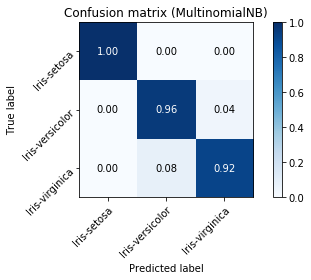

In [230]:
cross_validate(MultinomialNB, StratifiedKFold(50), X, y)

Teraz zrób to samo dla zbioru glass

A na co się przydaje ta dyskretyzacja? Sprawdźmy!

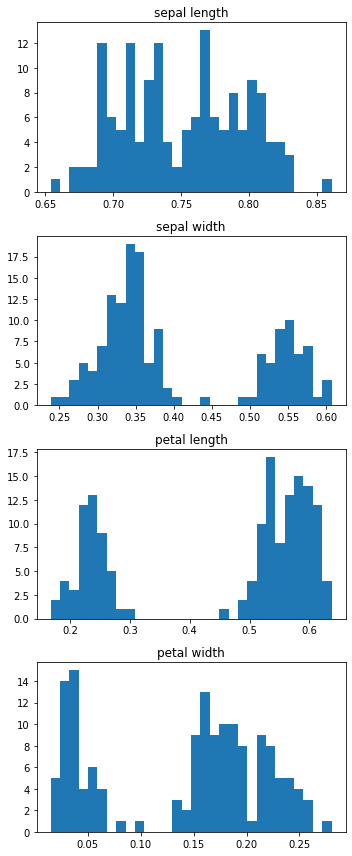

In [231]:
fig, axs = plt.subplots(len(X.columns), figsize=(5, len(X.columns)*3))
for index, column in enumerate(X):
    axs[index].hist(X[column], bins=30)
    axs[index].set_title(column)
plt.tight_layout()
plt.show()

In [100]:
def equal_length(column, n_bins):
    # metoda pandasa do podziału zbioru na jednakową frakwencję (częstość)
    indices, bins = pd.cut(column, n_bins, labels=False, retbins=True, duplicates='drop')
    return indices.map(dict(enumerate(bins)))

def equal_frequency(column, n_bins):
    # metoda pandasa do podziału zbioru na jednakową frakwencję (częstość)
    indices, bins = pd.qcut(column, n_bins, labels=False, retbins=True, duplicates='drop') 
    return indices.map(dict(enumerate(bins)))

def automatic_binning(column):
    # podział na przedziały zależy tu od histogramu
    _, bins = np.histogram(column, bins='fd')
    indices = pd.Series(np.digitize(column, bins) - 1)
    return indices.map(dict(enumerate(bins)))

length_binning = lambda x: equal_length(x, 5)
freq_binning = lambda x: equal_frequency(x, 5)

In [233]:
X_l = X.apply(length_binning)
X_f = X.apply(freq_binning)
X_a = X.apply(automatic_binning)

Results for GaussianNB
----
  Accuracy:  0.9
  Precision: 0.9
  Recall:    0.9
  F1 score:  0.9
  Mislabeled 15 out of 150




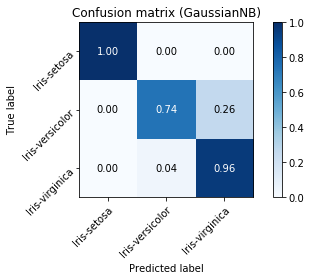

In [234]:
cross_validate(GaussianNB, StratifiedKFold(50), X_l, y)

Results for GaussianNB
----
  Accuracy:  0.9266666666666666
  Precision: 0.9266666666666666
  Recall:    0.9266666666666666
  F1 score:  0.9266666666666666
  Mislabeled 11 out of 150




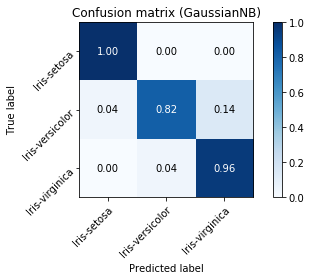

In [235]:
cross_validate(GaussianNB, StratifiedKFold(50), X_f, y)

Results for GaussianNB
----
  Accuracy:  0.9333333333333333
  Precision: 0.9333333333333333
  Recall:    0.9333333333333333
  F1 score:  0.9333333333333333
  Mislabeled 10 out of 150




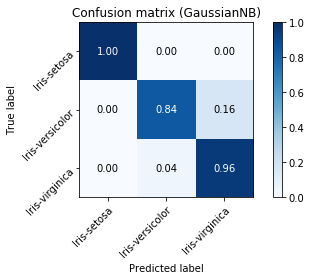

In [236]:
cross_validate(GaussianNB, StratifiedKFold(50), X_a, y)

In [76]:
def plot_results(result_df, title):
    ind = np.arange(len(result_df))
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 1 / len(result_df.columns)
    ax.bar(ind, result_df['accuracy'], width=width,
           label='Accuracy')
    ax.bar(ind+width, result_df['precision'], width=width,
           label='Precision')
    ax.bar(ind+2*width, result_df['recall'], width=width,
           label='Recall')
    ax.bar(ind+3*width, result_df['fscore'], width=width,
           label='fscore')
    
    ax.set_title(title)
    ax.set_ylabel('Scores')
    ax.set_xlabel(result_df.index.name)
    ax.set_xticks(ind + 3 * width / 2)
    ax.set_xticklabels(result_df.index)
    ax.autoscale()
    ax.legend()
    return ax

def test_params(X, y, classifier, classifier_param, classifier_const_params=None,
                kfold=None,
                normalizer=None, binning=None):
    X = X.copy()
    if classifier_const_params is None:
        classifier_const_params = {}
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    param = list(classifier_param.keys())[0]
    data = {param: [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, value in enumerate(list(classifier_param.values())[0]):
        kwargs = {param: value}
        clf = classifier(**kwargs, **classifier_const_params)
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(clf,
                                     kfold,
                                     X, y,
                                     talk=False)
        data[param].append(value)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index(param)
    return plot_results(df, f'{clf.__class__.__name__} - {param}'), df

/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: 

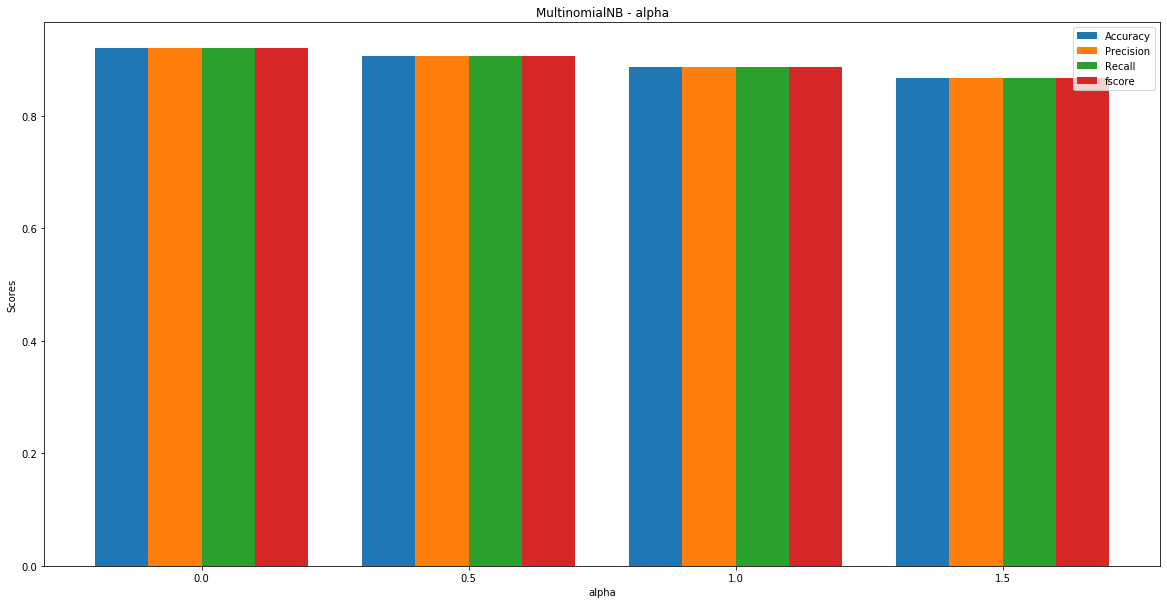

,accuracy,precision,recall,fscore,cm
alpha,,,,,
0.0,0.920000,0.920000,0.920000,0.920000,"[[50, 0, 0], [0, 44, 6], [0, 6, 44]]"
0.5,0.906667,0.906667,0.906667,0.906667,"[[50, 0, 0], [0, 43, 7], [0, 7, 43]]"
1.0,0.886667,0.886667,0.886667,0.886667,"[[50, 0, 0], [0, 43, 7], [0, 10, 40]]"
1.5,0.866667,0.866667,0.866667,0.866667,"[[50, 0, 0], [0, 40, 10], [0, 10, 40]]"


In [59]:
ax, results = test_params(X, y, MultinomialNB, {'alpha': np.arange(0, 2, 0.5)},
                         kfold=KFold(10, shuffle=True))
plt.show()
results

In [95]:
def test_classifiers(X, y, classifiers,
                     kfold=None,
                     normalizer=None, binning=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'classifier': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, classifier in enumerate(classifiers):
        name =  f"{classifier.__class__.__name__}-{index}"
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['classifier'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('classifier')
    return plot_results(df, 'Classifiers comparison'), df

(<matplotlib.axes._subplots.AxesSubplot at 0x1a23b6bbe0>,
                  accuracy  precision    recall    fscore  \
 classifier                                                 
 GaussianNB-0     0.926667   0.926667  0.926667  0.926667   
 MultinomialNB-1  0.953333   0.953333  0.953333  0.953333   
 
                                                    cm  
 classifier                                             
 GaussianNB-0     [[49, 1, 0], [0, 44, 6], [0, 4, 46]]  
 MultinomialNB-1  [[50, 0, 0], [0, 46, 4], [0, 3, 47]]  )

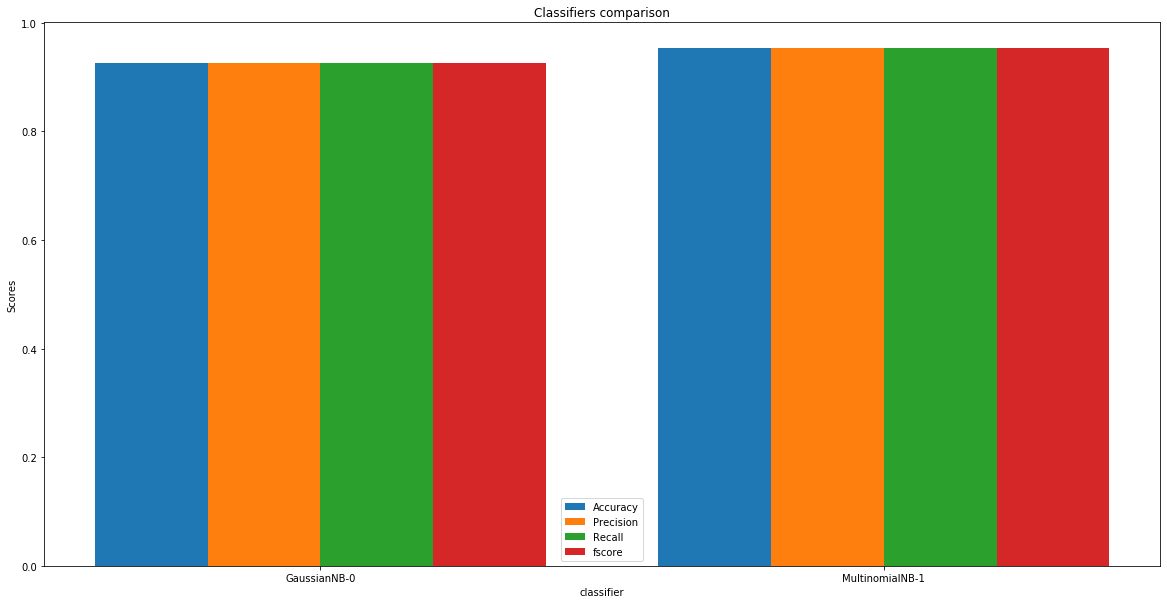

In [101]:
test_classifiers(X, y, [GaussianNB(), MultinomialNB()])

In [104]:
def test_folds(X, y, classifier, folds, kfold=None,
               normalizer=None, binning=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'folds': folds,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for n in folds:
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold(n),
                                     X, y,
                                     talk=False)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('folds')
    return plot_results(df, 'Number of folds'), df

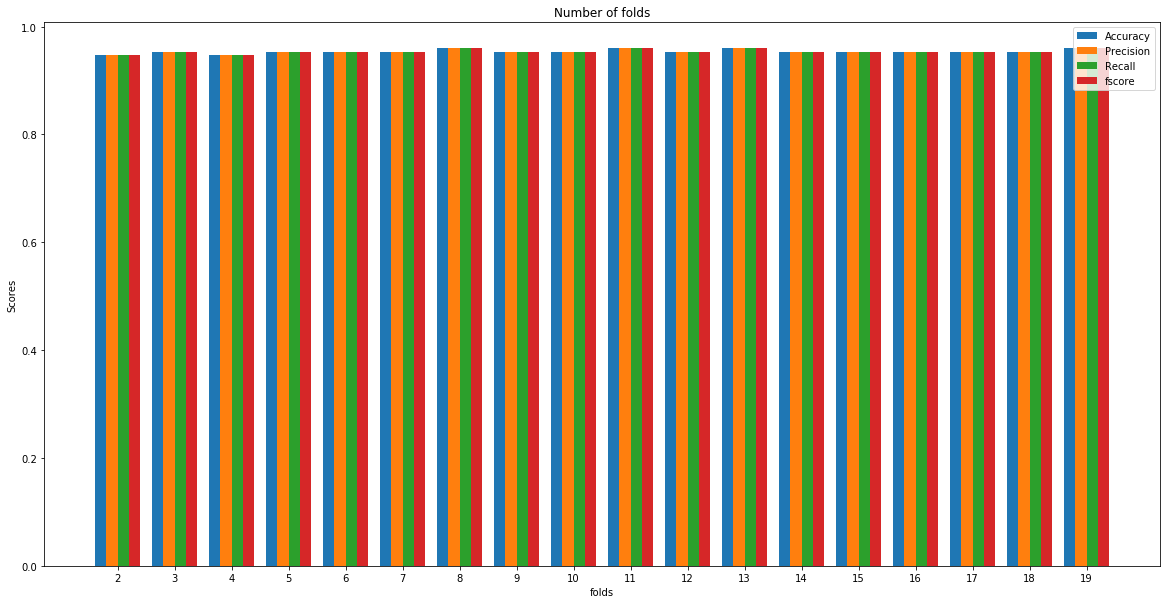

,accuracy,precision,recall,fscore,cm
folds,,,,,
2,0.946667,0.946667,0.946667,0.946667,"[[50, 0, 0], [0, 46, 4], [0, 4, 46]]"
3,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 46, 4], [0, 3, 47]]"
4,0.946667,0.946667,0.946667,0.946667,"[[50, 0, 0], [0, 46, 4], [0, 4, 46]]"
5,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 47, 3], [0, 4, 46]]"
6,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 47, 3], [0, 4, 46]]"
7,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 47, 3], [0, 4, 46]]"
8,0.960000,0.960000,0.960000,0.960000,"[[50, 0, 0], [0, 47, 3], [0, 3, 47]]"
9,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 47, 3], [0, 4, 46]]"
10,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 47, 3], [0, 4, 46]]"


In [119]:
ax, df = test_folds(X, y, GaussianNB, range(2,20,1), kfold=lambda x: KFold(x, shuffle=True))
plt.show()
df

In [116]:
def test_cross_val(X, y, classifier, kfolds,
               normalizer=None, binning=None):
    X = X.copy()
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'cross_val': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, kfold in enumerate(kfolds):
        name = f'{kfold.__class__.__name__}-{kfold.n_splits}_{index}'
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['cross_val'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('cross_val')
    return plot_results(df, 'Cross-validation method'), df

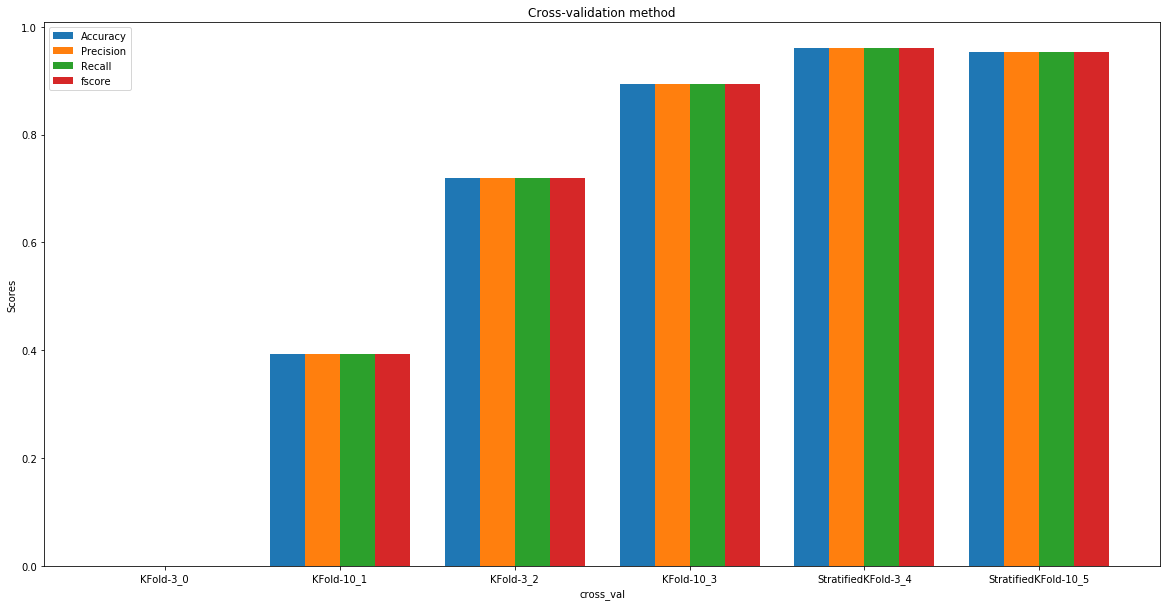

In [117]:
ax, df = test_cross_val(X, y, MultinomialNB(), [KFold(3, False), KFold(10, False), KFold(3, True), KFold(10, True), StratifiedKFold(3), StratifiedKFold(10)])

In [123]:
def test_normalization(X, y, classifier, normalizers,
                       kfold=None, binning=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'normalizer': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, normalizer in enumerate(normalizers):
        name = f'{normalizer.__class__.__name__}_{index}'
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X_new = X.copy()
        X_new[:] = X_preprocessed
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X_new, y,
                                     talk=False)
        data['normalizer'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('normalizer')
    return plot_results(df, 'Normalization method'), df

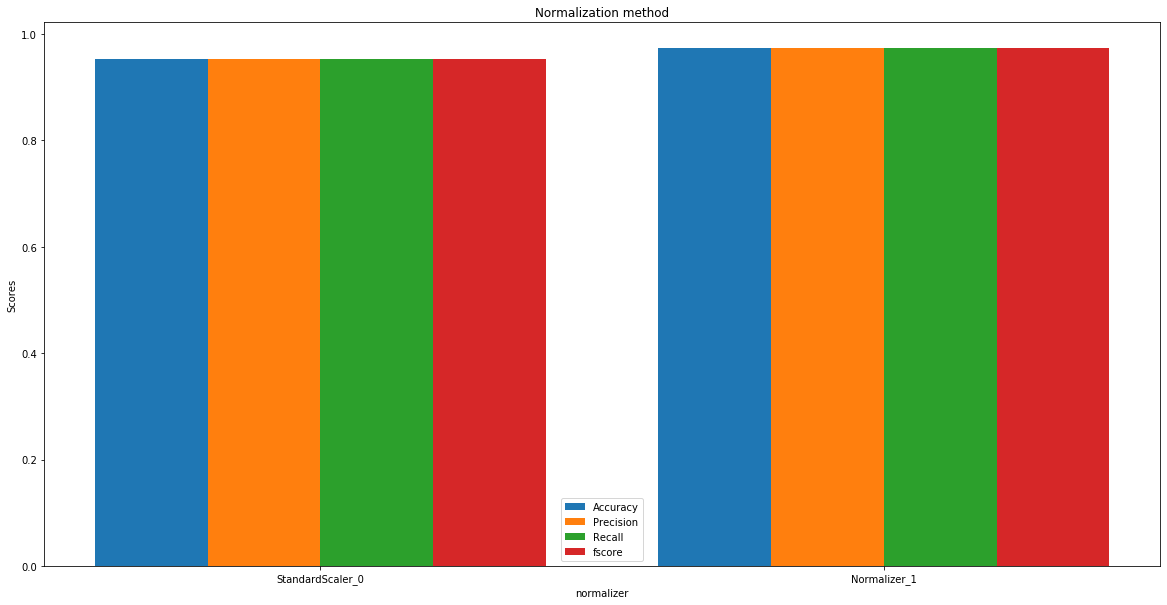

In [124]:
ax, df = test_normalization(X, y, GaussianNB(), [standardizer, normalizer])

In [126]:
def test_binning(X, y, classifier, binnings,
                       kfold=None, normalizer=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'binning': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, binning in enumerate(binnings):
        name = f'{binning.__name__}_{index}'
        X_binned = X.apply(binning)
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X_binned, y,
                                     talk=False)
        data['binning'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('binning')
    return plot_results(df, 'Binning method'), df

(<matplotlib.axes._subplots.AxesSubplot at 0x1a25ea76a0>,
                      accuracy  precision    recall    fscore  \
 binning                                                        
 <lambda>_0           0.793333   0.793333  0.793333  0.793333   
 <lambda>_1           0.960000   0.960000  0.960000  0.960000   
 <lambda>_2           0.940000   0.940000  0.940000  0.940000   
 <lambda>_3           0.953333   0.953333  0.953333  0.953333   
 <lambda>_4           0.740000   0.740000  0.740000  0.740000   
 <lambda>_5           0.953333   0.953333  0.953333  0.953333   
 <lambda>_6           0.920000   0.920000  0.920000  0.920000   
 <lambda>_7           0.926667   0.926667  0.926667  0.926667   
 automatic_binning_8  0.926667   0.926667  0.926667  0.926667   
 
                                                          cm  
 binning                                                      
 <lambda>_0           [[50, 0, 0], [10, 19, 21], [0, 0, 50]]  
 <lambda>_1             [[49, 1, 0],

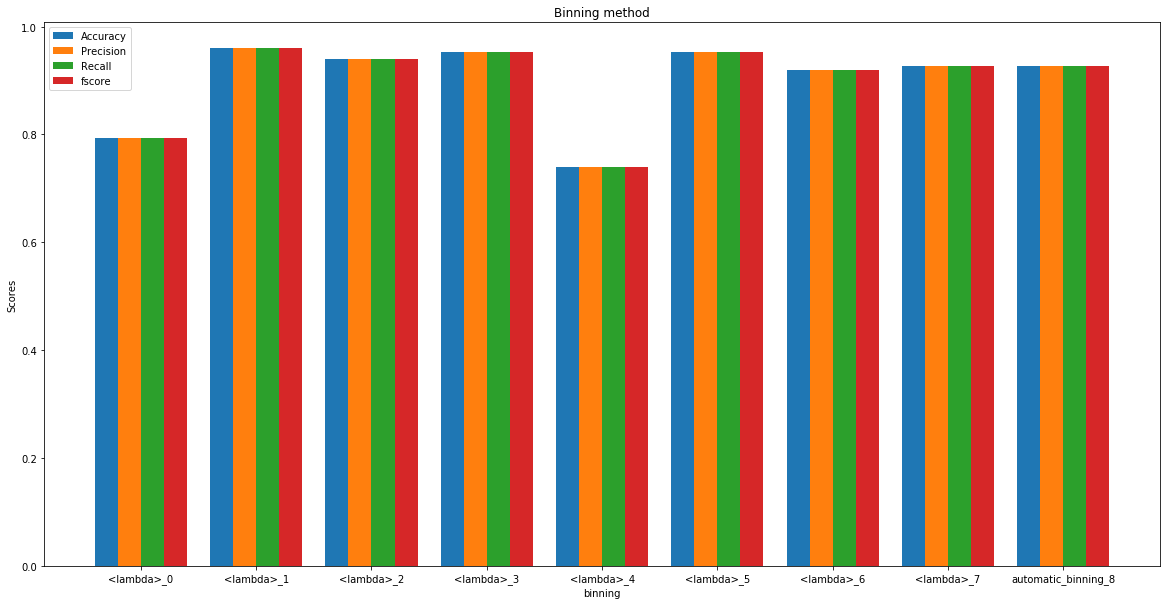

In [127]:
test_binning(X, y, GaussianNB, [lambda x: equal_length(x, 2),
                                lambda x: equal_length(x, 6),
                                lambda x: equal_length(x, 10),
                                lambda x: equal_length(x, 14),
                                lambda x: equal_frequency(x, 2),
                                lambda x: equal_frequency(x, 6),
                                lambda x: equal_frequency(x, 10),
                                lambda x: equal_frequency(x, 14),
                                automatic_binning])